In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from calibrate import loss_function
import matplotlib.pyplot as plt
from utils import display_order_book, to_float, to_json, extract_trades
from tqdm import tqdm
from orderBook import OrderBook, DollarsAndShares, PriceSizePairs, DynamicOrderBook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.rcParams['figure.figsize'] = (14, 8)

# Загрузка данных, обработка bids и asks.

In [2]:
df = pd.read_csv('data/OrderBook.csv', index_col=0)

df.bids = df.bids.apply(to_json)
df.asks = df.asks.apply(to_json)

df.bids = df.bids.apply(to_float)
df.asks = df.asks.apply(to_float)

df

,figi,depth,isConsistent,bids,asks,time,limitUp,limitDown,instrumentUid,orderBookType
id,,,,,,,,,,
1,BBG004730RP0,10,True,"[[122.55, 1.0], [122.54, 52.0], [122.53, 141.0...","[[122.57, 1.0], [122.58, 10.0], [122.59, 41.0]...",2024-11-22 07:48:31.826,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
2,BBG004730RP0,10,True,"[[122.55, 1.0], [122.53, 1.0], [122.52, 160.0]...","[[122.56, 41.0], [122.57, 211.0], [122.58, 717...",2024-11-22 07:48:32.306,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
3,BBG004730RP0,10,True,"[[122.55, 1.0], [122.54, 52.0], [122.53, 141.0...","[[122.57, 1.0], [122.58, 10.0], [122.59, 41.0]...",2024-11-22 07:48:31.989,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
4,BBG004730RP0,10,True,"[[122.53, 60.0], [122.52, 101.0], [122.51, 962...","[[122.56, 42.0], [122.57, 42.0], [122.58, 707....",2024-11-22 07:48:32.486,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
5,BBG004730RP0,10,True,"[[122.53, 71.0], [122.52, 101.0], [122.51, 762...","[[122.56, 64.0], [122.57, 42.0], [122.58, 707....",2024-11-22 07:48:32.936,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
...,...,...,...,...,...,...,...,...,...,...
10507,BBG004730RP0,10,True,"[[121.53, 5.0], [121.52, 101.0], [121.51, 364....","[[121.54, 10.0], [121.55, 572.0], [121.56, 1.0...",2024-11-22 09:07:38.593,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
10508,BBG004730RP0,10,True,"[[121.53, 5.0], [121.52, 101.0], [121.51, 374....","[[121.54, 10.0], [121.55, 572.0], [121.56, 1.0...",2024-11-22 09:07:39.087,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
10509,BBG004730RP0,10,True,"[[121.53, 5.0], [121.52, 101.0], [121.51, 374....","[[121.54, 10.0], [121.55, 572.0], [121.56, 1.0...",2024-11-22 09:07:39.396,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE


# Размерность bids и asks = $N \times depth \times 2$;
## $depth = C$, обычно $depth = 10$.

In [16]:
start_train_idx = np.random.randint(0, 10000)
end_train_idx = start_train_idx + np.random.randint(100, 300)

start_val_idx = end_train_idx + 1
end_val_idx = start_val_idx + 180

In [17]:
bids = []
asks = []

for i in range(start_train_idx, end_train_idx):
    
    bids.append([DollarsAndShares(
            dollars=x[0],
            shares=x[1]
        ) for x in df.bids.iloc[i]])
    
    asks.append([DollarsAndShares(
        dollars=x[0],
        shares=x[1]
    ) for x in df.asks.iloc[i]])
    
order_books = [DynamicOrderBook(descending_bids=bids[i], ascending_asks=asks[i]) for i in range(len(bids))]

# Извлечение трейдов из исторических данных

In [18]:
trades = extract_trades(order_books)

n_t = end_train_idx

trades_til_n = [] # трейды до момента времени н
times_til_n = [] # моменты трейдов до времени н

for i in tqdm(range(len(trades))):
    if trades[i][0] < n_t:
        trades_til_n.append(trades[i][1])
        times_til_n.append(trades[i][0])
        
trades_til_n = np.array(trades_til_n)
times_til_n = np.array(times_til_n)

trade_times = times_til_n
trade_volumes = trades_til_n

n = len(trade_times)

100%|██████████| 220/220 [00:00<00:00, 1898656.13it/s]


# Калибровка параметра $\lambda$

In [19]:
import numpy as np
import statsmodels.api as sm


mid_prices = np.array([order_books[i].mid_price() for i in trade_times])
trades = extract_trades(order_books)

trades_tmp = []
for i in range(len(trade_times)):
    trades_tmp.append(trades[i][1])
    
trades_tmp = np.array(trades_tmp)

X_cum = np.cumsum(trades_tmp)


# Строим такую регрессию: $V_t - V_0$ = $\lambda(X_t - X_0)$

In [20]:
V0 = mid_prices[0]
X0 = X_cum[0]

y = mid_prices - V0
X = X_cum - X0

X_design = sm.add_constant(X)
model = sm.OLS(y, X_design)
results = model.fit()

lambda_est = results.params[1] 
intercept = results.params[0]

print(f"lambda = {lambda_est}")
print(f"intercept = {intercept}")
print(results.summary())

lambda = 3.6129499928724277e-06
intercept = 0.014858363216658399
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1182.
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           5.24e-90
Time:                        14:14:07   Log-Likelihood:                 661.57
No. Observations:                 220   AIC:                            -1319.
Df Residuals:                     218   BIC:                            -1312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

# Калибровка параметра $\rho$

In [21]:
trade_times = times_til_n
trade_volumes = trades_til_n

asks = np.array([order_books[i].ask_price() for i in trade_times])

fixed_k = 1/abs(lambda_est)

initial_r = [0.1]
spread = order_books[0].bid_ask_spread()  # s
mid_price = order_books[0].mid_price()    # V_t

# Оптимизируем только r при фиксированном k
result = minimize(
    loss_function,
    initial_r,
    args=(trade_times, trade_volumes, np.array(asks), spread, mid_price, fixed_k),
    bounds=[(1e-9, 70)],  # Ограничения только для r
    method='L-BFGS-B'
)

optimized_r = result.x[0]

print("k:", fixed_k)
print("r_opt:", optimized_r)

k: 276782.1314916577
r_opt: 1e-09


# Моделирование аск прайса
# Инициализация параметров

In [22]:
lmbd = lambda_est
s = order_books[0].bid_ask_spread()
r = optimized_r

N = len(order_books) - 1
T = 1.0 
dt = T / N
t_grid = np.linspace(0, T, N+1)

# Моделируем цену $F_t$ как броуновское движение $W_t$

100%|██████████| 149/149 [00:00<00:00, 644944.58it/s]


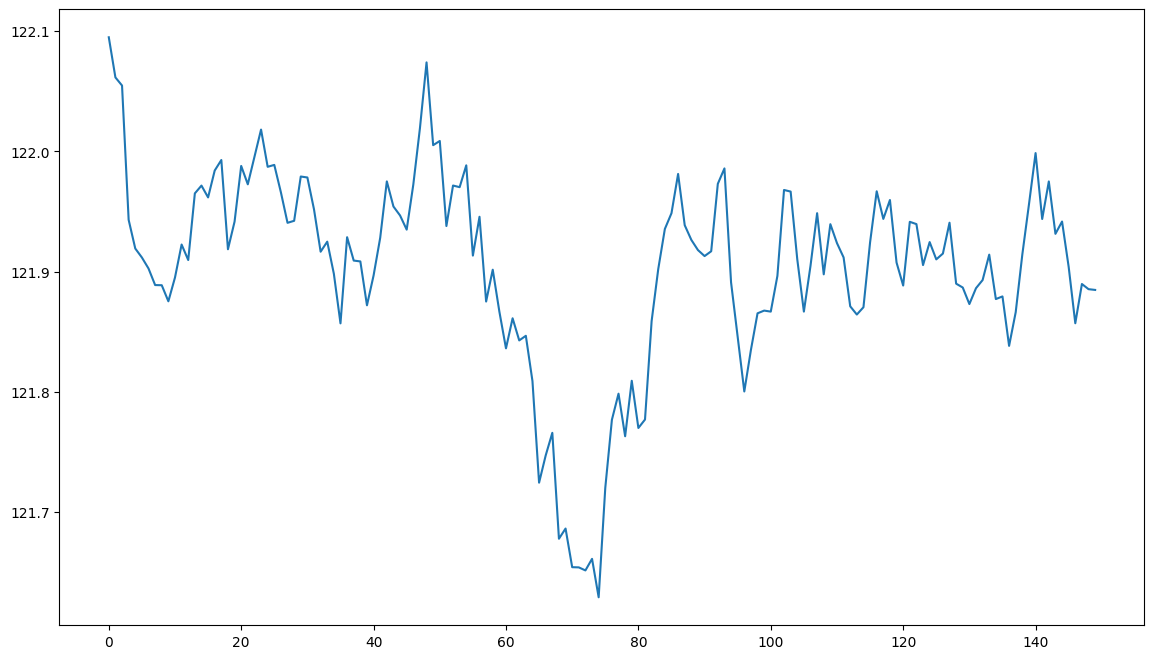

In [23]:
F0 = order_books[0].mid_price()
mu = 0.0
sigma = .5 # TODO: подумаьт что сделать с волтатильностью
z = np.random.randn(N)
F = np.zeros(N+1)

F[0] = F0
for i in tqdm(range(1, N+1)):
    F[i] = F[i-1] + mu*dt + sigma*np.sqrt(dt)*z[i-1]

plt.plot(F)

In [24]:
trades_list = DynamicOrderBook.extract_trades(order_books)

# Преобразуем сделки в формат (normalized_t, trade_value) с учётом временной сетки
trades_history = [(t_grid[t_idx], x_val) for (t_idx, x_val) in trades_list]

# Рассчет $X_t$

In [25]:
# Для каждого времени t_grid[i], найдём сумму всех сделок, произошедших до этого момента.
X_t = np.zeros(N+1)

trades_history.sort(key=lambda x: x[0])

for i in tqdm(range(1, N+1)):
    cum_sum = 0.0
    current_time = t_grid[i]
    
    for (tau, x_val) in trades_history:
        if tau <= current_time:
            cum_sum += x_val
        else:
            break
    X_t[i] = cum_sum

100%|██████████| 149/149 [00:00<00:00, 42987.43it/s]


# $V_t = F_t + \lambda X_t$

In [26]:
V = F + lmbd * X_t

# Рассчёт A_t
A = np.zeros(N+1)
for i in tqdm(range(N+1)):
    t_current = t_grid[i]
    sum_term = 0.0
    for (tau, x_val) in trades_history:
        if tau <= t_current:
            time_diff = t_current - tau
            sum_term += x_val * np.exp(-r * time_diff)
        else:
            break
    A[i] = V[i] + s/2 + (1.0/lmbd)*sum_term

A[0] = F0 + s/2

100%|██████████| 150/150 [00:00<00:00, 8177.94it/s]


In [27]:
trades_a = []
for i in range(len(trades_list)):
    trades_a.append(trades_list[i][0])
trades_a = np.array(trades_a)
trades_a.shape

(220,)

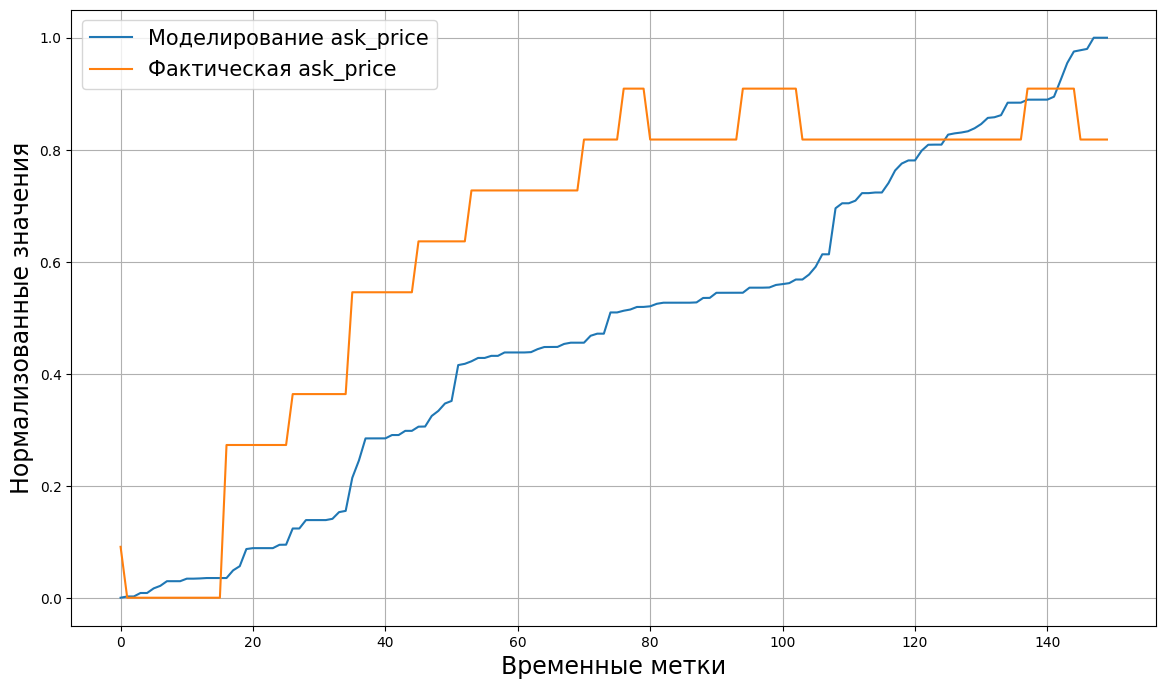

In [28]:
scaler = MinMaxScaler()

a_sc = scaler.fit_transform(A.reshape(-1, 1))
asks = np.array([order_books[i].ask_price() for i in trades_a])
asks_sc = scaler.fit_transform(asks.reshape(-1, 1))

plt.plot(a_sc, label='Моделирование ask_price')
plt.plot(asks_sc[:len(a_sc)], label='Фактическая ask_price')
plt.xlabel('Временные метки', fontsize=17)
plt.ylabel('Нормализованные значения', fontsize=17)
plt.legend(fontsize=15)
plt.grid()
plt.show()

# NOTES!!!
# Модель очень сильно зависит от калибровки параметра $\rho$, достаточно часто модель отрабатывает хорошо, но иногда бывают сбои ТЕСТ!!!
# Не понятно в каких масштабах мы работаем, вернее понятно что моделируется тренд и вроде как на масштаб все равно, но стоит подумтаь больше!